# Inverse Options in a Black-Scholes World

Options on cryptocurrencies are mainly traded on Deribit (over 90% market share based on https://www.theblockcrypto.com/data/crypto-markets/options). Unlike the ones on CME or LedgerX, they are what the authers call *inverse options* where the terminal payoff is written as follows: 

$$
C_T = {\rm max} \left(S_T - K, 0 \right) / S_T
$$

for a call option. This is because options are quoted and settled in BTC (or ETH). This creates an interesting characteris not only in the termianl payoff but also on the pricing formula and Greeks.

# Present values and payoffs

First, let's recreate the figure 3 in [1]

## Some definition and calculations

In [1]:
from datetime import datetime
from itertools import product
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import brentq
import seaborn as sns
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
plt.style.use('bmh')

from vivace.backtest.contract import get_deribit_option_snapshot, get_perpetual_futures

In [2]:
class BaseOption:
    """ Base class for options """ 
    def __init__(self, strike: float, option_type: int):
        self.strike = strike
        self.option_type = option_type  # 1 for call, -1 for put

    @property
    def call_or_put(self) -> str:
        if self.option_type == 1:
            return 'call'
        else:
            return 'put'

    def _d1(self, underlying: float, sigma: float, tau: float, r: float, div: float) -> float:
        return (np.log(underlying / self.strike) + (r - div + 0.5 * sigma ** 2) * tau) / (sigma * tau ** 0.5)
    
    def _d2(self, underlying: float, sigma: float, tau: float, r: float, div: float) -> float:
        return self._d1(underlying, sigma, tau, r, div) - sigma * tau ** 0.5

    def implied_volatility(self, pv: float, underlying: float, tau: float, r: float, div: float) -> float:
        """ Solve the implied volatility which matches the given PV """
        # The upper bound is extended incrementally so that f(a) and f(b) can be the opposite sign.
        # Needed for inverse options as they can be both positive and negative vega depending on sigma
        max_sigma = [1, 3, 5, 10]
        result = None
        
        def obj(sigma):
            return pv - self.pv(underlying, sigma, tau, r, div)
        
        for i in max_sigma:
            try:
                result = brentq(obj, 1e-5, i)
                break
            except ValueError:
                # f(a) and f(b) must have different signs
                pass
        
        if result is None:
            return np.nan
        else:
            return result
    
    
class DirectOption(BaseOption):
    """ Direct options """
        
    def pv(self, underlying: float, sigma: float, tau: float, r: float, div: float) -> float:
        d1 = self._d1(underlying, sigma, tau, r, div)
        d2 = self._d2(underlying, sigma, tau, r, div)
        
        term1 = np.exp(-div * tau) * underlying * norm.cdf(self.option_type * d1)
        term2 = np.exp(-r * tau) * self.strike * norm.cdf(self.option_type * d2)
        return self.option_type * (term1 - term2)
    
    def delta(self, underlying: float, sigma: float, tau: float, r: float, div: float) -> float:
        d1 = self._d1(underlying, sigma, tau, r, div)
        return self.option_type * np.exp(-div * tau) * norm.cdf(self.option_type * d1)
    
    def gamma(self, underlying: float, sigma: float, tau: float, r: float, div: float) -> float:
        d1 = self._d1(underlying, sigma, tau, r, div)
        return np.exp(-div * tau) * norm.pdf(d1) / (underlying * sigma * tau ** 0.5)
    
    def vega(self, underlying: float, sigma: float, tau: float, r: float, div: float) -> float:
        d1 = self._d1(underlying, sigma, tau, r, div)
        return np.exp(-div * tau) * underlying * norm.pdf(d1) * tau ** 0.5
    
    def theta(self, underlying: float, sigma: float, tau: float, r: float, div: float) -> float:
        """ Theta per 1 year. 
        From wikipedia, and the direction of theta is the pnl as the expiry shrinks (-dP/dtau) """
        d1 = self._d1(underlying, sigma, tau, r, div)
        d2 = self._d2(underlying, sigma, tau, r, div)
        
        term1 = -np.exp(-div * tau) * underlying * norm.pdf(d1) * sigma / (2 * tau ** 0.5)
        term2 = self.option_type * r * self.strike * np.exp(-r * tau) * norm.cdf(self.option_type * d2)
        term3 = self.option_type * div * underlying * np.exp(-div * tau) * norm.cdf(self.option_type * d1)
        return term1 - term2 + term3
    
    
class InverseOption(BaseOption):
    """ Inverse options """
    
    def _d3(self, underlying: float, sigma: float, tau: float, r: float, div: float):
        return self._d2(underlying, sigma, tau, r, div) - sigma * tau ** 0.5
    
    def pv(self, underlying: float, sigma: float, tau: float, r: float, div: float) -> float:
        d2 = self._d2(underlying, sigma, tau, r, div)
        d3 = self._d3(underlying, sigma, tau, r, div)
        
        term1 = np.exp(-r * tau) * norm.cdf(self.option_type * d2)
        term2 = np.exp((div - r + sigma ** 2) * tau) / underlying * self.strike * norm.cdf(self.option_type * d3)
        return self.option_type * (term1 - term2)
    
    def delta(self, underlying: float, sigma: float, tau: float, r: float, div: float) -> float:
        d3 = self._d3(underlying, sigma, tau, r, div)
        return self.option_type * np.exp(sigma ** 2 * tau) / (underlying ** 2) * self.strike * norm.cdf(self.option_type * d3)
    
    def gamma(self, underlying: float, sigma: float, tau: float, r: float, div: float) -> float:
        d3 = self._d3(underlying, sigma, tau, r, div)
        term1 = norm.pdf(self.option_type * d3) / (sigma * tau ** 0.5)
        term2 = 2 * self.option_type * norm.cdf(self.option_type * d3)
        return np.exp(sigma ** 2 * tau) / (underlying ** 3) * self.strike * (term1 - term2)
    
    def vega(self, underlying: float, sigma: float, tau: float, r: float, div: float) -> float:
        d2 = self._d2(underlying, sigma, tau, r, div)
        d3 = self._d3(underlying, sigma, tau, r, div)
        term1 = norm.pdf(d2) * tau ** 0.5
        term2 = 2 * self.option_type * np.exp(sigma ** 2 * tau) * sigma * tau / underlying * self.strike * norm.cdf(self.option_type * d3)
        return term1 - term2
    
    def theta(self, underlying: float, sigma: float, tau: float, r: float, div: float) -> float:
        """ Theta per 1 year. 
        The direction of theta is the pnl as the expiry shrinks (-dP/dtau) """
        d2 = self._d2(underlying, sigma, tau, r, div)
        d3 = self._d3(underlying, sigma, tau, r, div)
        term1 = 0.5 * norm.pdf(d2) * sigma / (tau ** 0.5)
        term2 = self.option_type * self.strike / underlying * np.exp(sigma ** 2 * tau) * (sigma ** 2) * norm.cdf(self.option_type * d3)
        return -1 * (term1 - term2)

In [3]:
sigma = 0.8
strike = 65000
r = 0
div = 0
tau_map = {
    '0d': 1e-10,
    '10d': 10 / 365,
    '3m': 3 / 12,
    '6m': 6 / 12,
    '1y': 1,
}
underlying_list = np.linspace(1e4, 1e5)

direct_call = DirectOption(strike, 1)
direct_put = DirectOption(strike, -1)
inverse_call = InverseOption(strike, 1)
inverse_put = InverseOption(strike, -1)

In [4]:
options = [direct_call, direct_put, inverse_call, inverse_put]
terminal_payoff_data = []

for tau, underlying, trade in product(tau_map.keys(), underlying_list, options):
    tau_float = tau_map[tau]
    terminal_payoff_data.append([
        tau, underlying, trade.__class__.__name__, trade.call_or_put, 
        trade.pv(underlying, sigma, tau_float, r, div),
        trade.delta(underlying, sigma, tau_float, r, div),
        trade.gamma(underlying, sigma, tau_float, r, div),
        trade.vega(underlying, sigma, tau_float, r, div),
        trade.theta(underlying, sigma, tau_float, r, div),
    ])
    
terminal_payoff_data = pd.DataFrame(terminal_payoff_data, 
                                    columns=['tau', 'underlying', 'class_name', 'call_or_put', 
                                             'pv', 'delta', 'gamma', 'vega', 'theta'])

## PV in premium currency

The charts below show the present values expressed in USD and BTC for direct options and inverse options respectively. 
As noted in [1], because of the $\frac{1}{S_T}$ in the terminal payoff, the inverse option payoff, for instance, exhibits convexity even at maturity. The inverse call option becomes concave as it becomes deep ITM and approaches the upper bound at 1 BTC. This is in some sense analogous to swaptions whose terminal payoff is dependent on the annuity factor (PV01), thus the terminal payoff for payer swaptions (which corresponds to the inverse call option) becomes concave as it becomes ITM due to smaller PV01.

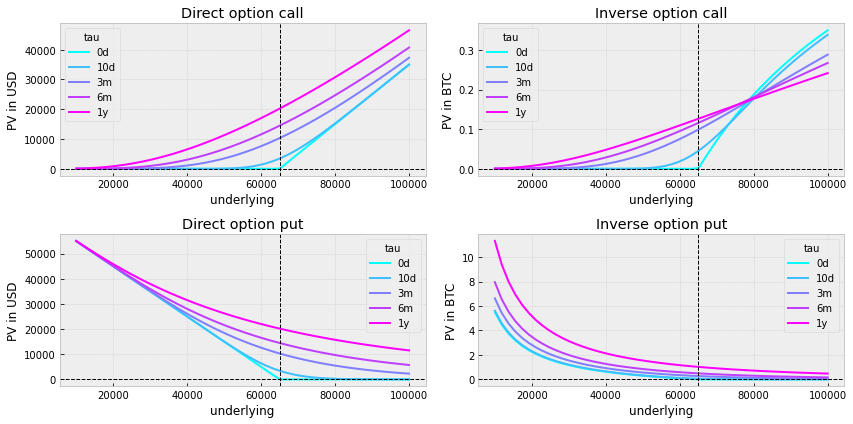

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
(terminal_payoff_data
 .query('class_name == "DirectOption" and call_or_put == "call"')
 .pivot_table('pv', index='underlying', columns='tau')
 .reindex(columns=tau_map)
 .plot(cmap='cool', ax=ax[0][0]))
(terminal_payoff_data
 .query('class_name == "DirectOption" and call_or_put == "put"')
 .pivot_table('pv', index='underlying', columns='tau')
 .reindex(columns=tau_map)
 .plot(cmap='cool', ax=ax[1][0]))

(terminal_payoff_data
 .query('class_name == "InverseOption" and call_or_put == "call"')
 .pivot_table('pv', index='underlying', columns='tau')
 .reindex(columns=tau_map)
 .plot(cmap='cool', ax=ax[0][1]))
(terminal_payoff_data
 .query('class_name == "InverseOption" and call_or_put == "put"')
 .pivot_table('pv', index='underlying', columns='tau')
 .reindex(columns=tau_map)
 .plot(cmap='cool', ax=ax[1][1]));

axes = ax.flatten()
for i in axes:
    i.axhline(0, color='black', lw=1, ls='--')
    i.axvline(strike, color='black', lw=1, ls='--')

ax[0][0].set_title('Direct option call')
ax[1][0].set_title('Direct option put')
ax[0][0].set_ylabel('PV in USD')
ax[1][0].set_ylabel('PV in USD')

ax[0][1].set_title('Inverse option call')
ax[1][1].set_title('Inverse option put')
ax[0][1].set_ylabel('PV in BTC')
ax[1][1].set_ylabel('PV in BTC')
fig.tight_layout()

## PV in USD

The charts below show the same PV evolution but all expressed in USD. Once they are expressed in the same currency, both options eventually show the same terminal payoff as the inverse call option's payoff becomes just $\left( S_T - K \right)^+ / S_T \cdot S_T$. However prior to expiry, they return different PVs as the one is the expected present value of $\left( S_T - K \right)^+$ while the other is $\left( S_T - K \right)^+ / S_T$.

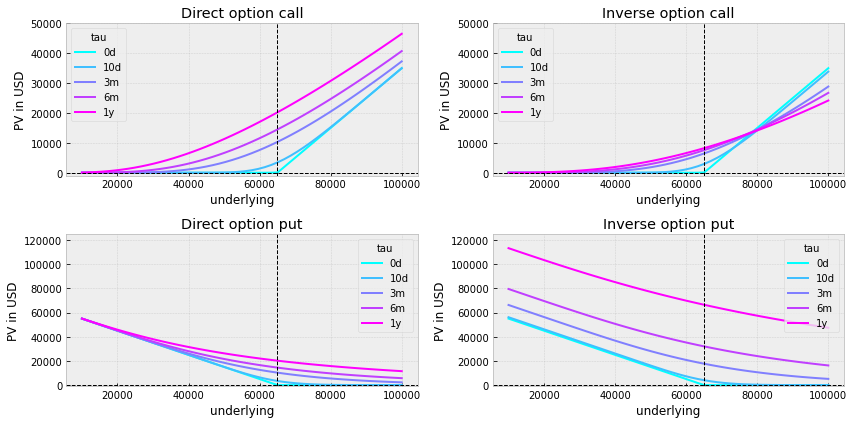

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
(terminal_payoff_data
 .query('class_name == "DirectOption" and call_or_put == "call"')
 .pivot_table('pv', index='underlying', columns='tau')
 .reindex(columns=tau_map)
 .plot(cmap='cool', ax=ax[0][0]))
(terminal_payoff_data
 .query('class_name == "DirectOption" and call_or_put == "put"')
 .pivot_table('pv', index='underlying', columns='tau')
 .reindex(columns=tau_map)
 .plot(cmap='cool', ax=ax[1][0]))

(terminal_payoff_data
 .query('class_name == "InverseOption" and call_or_put == "call"')
 .assign(
     pv_in_usd=lambda df: df['pv'] * df['underlying']
 )
 .pivot_table('pv_in_usd', index='underlying', columns='tau')
 .reindex(columns=tau_map)
 .plot(cmap='cool', ax=ax[0][1]))
(terminal_payoff_data
 .query('class_name == "InverseOption" and call_or_put == "put"')
 .assign(
     pv_in_usd=lambda df: df['pv'] * df['underlying']
 )
 .pivot_table('pv_in_usd', index='underlying', columns='tau')
 .reindex(columns=tau_map)
 .plot(cmap='cool', ax=ax[1][1]));

axes = ax.flatten()
for i in axes:
    i.axhline(0, color='black', lw=1, ls='--')
    i.axvline(strike, color='black', lw=1, ls='--')
    i.set_ylabel('PV in USD')

ax[0][0].set_title('Direct option call')
ax[1][0].set_title('Direct option put')
ax[0][0].set_ylim(-1000, 50000)
ax[0][1].set_ylim(-1000, 50000)

ax[0][1].set_title('Inverse option call')
ax[1][1].set_title('Inverse option put')
ax[1][0].set_ylim(-1000, 125_000)
ax[1][1].set_ylim(-1000, 125_000)
fig.tight_layout()

# Greeks

## Delta

In direct options, its delta is bound between 0 and 1 for call options as it's essentially the cumulative distribution function of Gaussian.
On the other hand, for inverse options, although delta remains positive for all underlying values, there is a point where the delta starts to decline once it becomes deep ITM (i.e., *negative* gamma). For the avoidance of doubt, the delta of a direct option is $\frac{\partial P_{USD}}{\partial S}$ while the inverse option is $\frac{\partial P_{BTC}}{\partial S}$ where $P_X$ is the present value expressed in a currency $X$.

One thing to note is the delta for inverse options appears to be 
$$
\omega e^{\sigma^2\tau}F^{-2}KN(wd_3)
$$

with $d_3$, not $d_2$ as reported in [1].

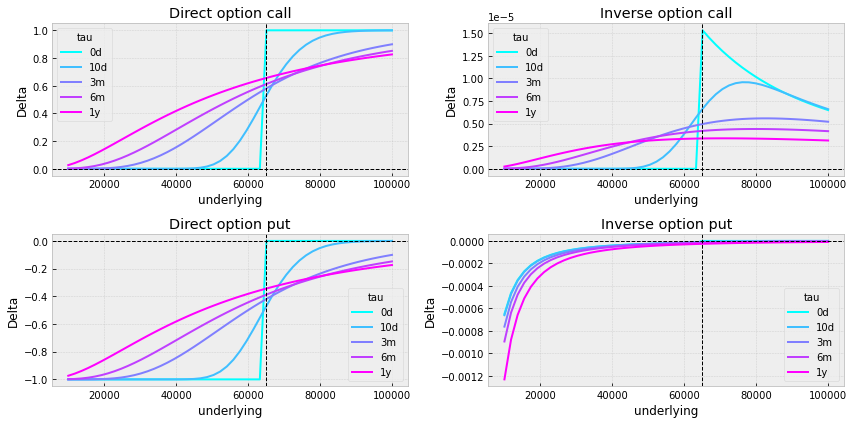

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
(terminal_payoff_data
 .query('class_name == "DirectOption" and call_or_put == "call"')
 .pivot_table('delta', index='underlying', columns='tau')
 .reindex(columns=tau_map)
 .plot(cmap='cool', ax=ax[0][0]))
(terminal_payoff_data
 .query('class_name == "DirectOption" and call_or_put == "put"')
 .pivot_table('delta', index='underlying', columns='tau')
 .reindex(columns=tau_map)
 .plot(cmap='cool', ax=ax[1][0]))

(terminal_payoff_data
 .query('class_name == "InverseOption" and call_or_put == "call"')
 .pivot_table('delta', index='underlying', columns='tau')
 .reindex(columns=tau_map)
 .plot(cmap='cool', ax=ax[0][1]))
(terminal_payoff_data
 .query('class_name == "InverseOption" and call_or_put == "put"')
 .pivot_table('delta', index='underlying', columns='tau')
 .reindex(columns=tau_map)
 .plot(cmap='cool', ax=ax[1][1]));

axes = ax.flatten()
for i in axes:
    i.axhline(0, color='black', lw=1, ls='--')
    i.axvline(strike, color='black', lw=1, ls='--')
    i.set_ylabel('Delta')

ax[0][0].set_title('Direct option call')
ax[1][0].set_title('Direct option put')

ax[0][1].set_title('Inverse option call')
ax[1][1].set_title('Inverse option put')
fig.tight_layout()

## Gamma

For direct options, gamma is the same for calls and puts. As noted above, for inverse call options, gamma can be negative.

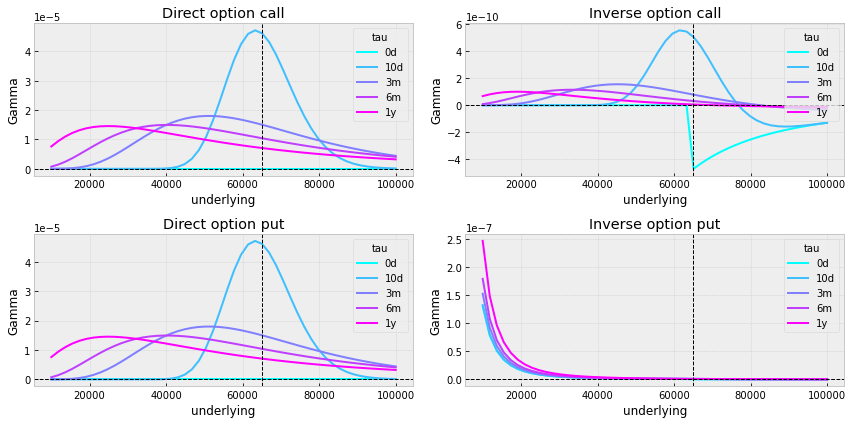

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
(terminal_payoff_data
 .query('class_name == "DirectOption" and call_or_put == "call"')
 .pivot_table('gamma', index='underlying', columns='tau')
 .reindex(columns=tau_map)
 .plot(cmap='cool', ax=ax[0][0]))
(terminal_payoff_data
 .query('class_name == "DirectOption" and call_or_put == "put"')
 .pivot_table('gamma', index='underlying', columns='tau')
 .reindex(columns=tau_map)
 .plot(cmap='cool', ax=ax[1][0]))

(terminal_payoff_data
 .query('class_name == "InverseOption" and call_or_put == "call"')
 .pivot_table('gamma', index='underlying', columns='tau')
 .reindex(columns=tau_map)
 .plot(cmap='cool', ax=ax[0][1]))
(terminal_payoff_data
 .query('class_name == "InverseOption" and call_or_put == "put"')
 .pivot_table('gamma', index='underlying', columns='tau')
 .reindex(columns=tau_map)
 .plot(cmap='cool', ax=ax[1][1]));

axes = ax.flatten()
for i in axes:
    i.axhline(0, color='black', lw=1, ls='--')
    i.axvline(strike, color='black', lw=1, ls='--')
    i.set_ylabel('Gamma')

ax[0][0].set_title('Direct option call')
ax[1][0].set_title('Direct option put')

ax[0][1].set_title('Inverse option call')
ax[1][1].set_title('Inverse option put')
fig.tight_layout()

## Theta

The authors somehow did not derive the theta for inverse options, but it can be computed just like other Greeks. The theta can be written as below:
$$
\frac{\partial P}{\partial \tau} = 
\frac{1}{2} n \left( d_2 \right) \frac{\sigma}{\sqrt{\tau}} - 
\omega \frac{K}{F} e^{\sigma^2 \tau} \sigma^2 N \left( \omega d_3 \right)
$$.

Note that the charts for theta below are expressed as tiem decay -- i.e., $-\frac{\partial P}{\partial \tau}$, the decrese in PV as the expiry *shrinks* by 1 year.

Because theta is basically a shadow of gamma, the theta for deep ITM call inverse options can be positive.

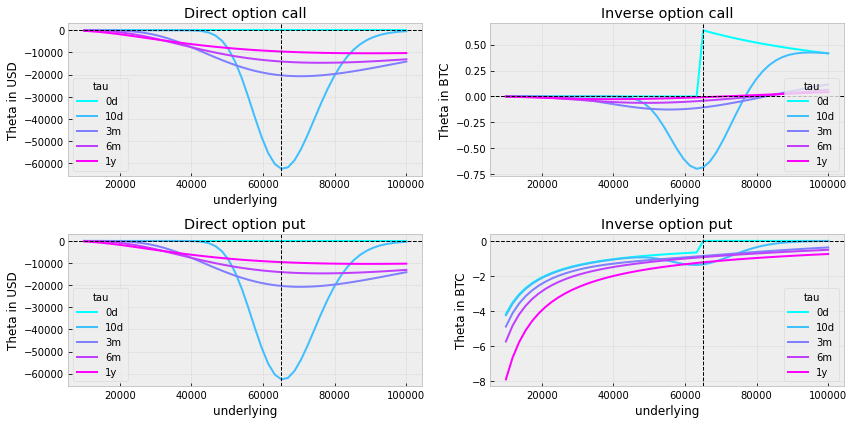

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
(terminal_payoff_data
 .query('class_name == "DirectOption" and call_or_put == "call"')
 .pivot_table('theta', index='underlying', columns='tau')
 .reindex(columns=tau_map)
 .plot(cmap='cool', ax=ax[0][0]))
(terminal_payoff_data
 .query('class_name == "DirectOption" and call_or_put == "put"')
 .pivot_table('theta', index='underlying', columns='tau')
 .reindex(columns=tau_map)
 .plot(cmap='cool', ax=ax[1][0]))

(terminal_payoff_data
 .query('class_name == "InverseOption" and call_or_put == "call"')
 .pivot_table('theta', index='underlying', columns='tau')
 .reindex(columns=tau_map)
 .plot(cmap='cool', ax=ax[0][1]))
(terminal_payoff_data
 .query('class_name == "InverseOption" and call_or_put == "put"')
 .pivot_table('theta', index='underlying', columns='tau')
 .reindex(columns=tau_map)
 .plot(cmap='cool', ax=ax[1][1]));

axes = ax.flatten()
for i in axes:
    i.axhline(0, color='black', lw=1, ls='--')
    i.axvline(strike, color='black', lw=1, ls='--')

ax[0][0].set_title('Direct option call')
ax[1][0].set_title('Direct option put')
ax[0][0].set_ylabel('Theta in USD')
ax[1][0].set_ylabel('Theta in USD')

ax[0][1].set_title('Inverse option call')
ax[1][1].set_title('Inverse option put')
ax[0][1].set_ylabel('Theta in BTC')
ax[1][1].set_ylabel('Theta in BTC')
fig.tight_layout()

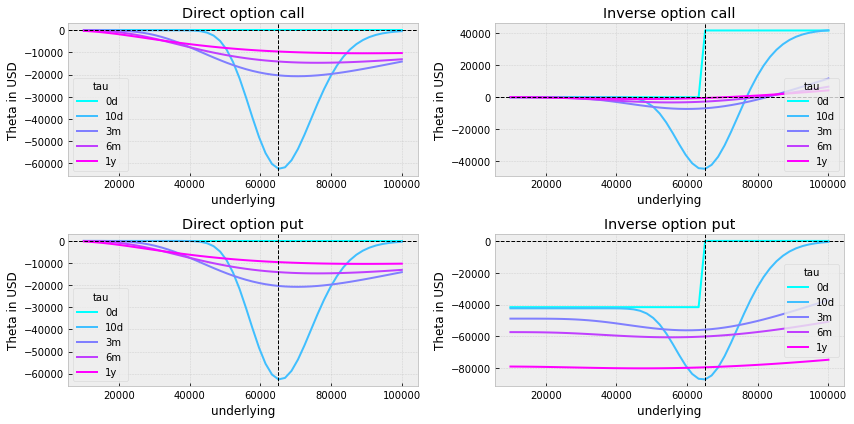

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
(terminal_payoff_data
 .query('class_name == "DirectOption" and call_or_put == "call"')
 .pivot_table('theta', index='underlying', columns='tau')
 .reindex(columns=tau_map)
 .plot(cmap='cool', ax=ax[0][0]))
(terminal_payoff_data
 .query('class_name == "DirectOption" and call_or_put == "put"')
 .pivot_table('theta', index='underlying', columns='tau')
 .reindex(columns=tau_map)
 .plot(cmap='cool', ax=ax[1][0]))

(terminal_payoff_data
 .query('class_name == "InverseOption" and call_or_put == "call"')
 .assign(
     theta_in_usd=lambda df: df['theta'] * df['underlying']
 )
 .pivot_table('theta_in_usd', index='underlying', columns='tau')
 .reindex(columns=tau_map)
 .plot(cmap='cool', ax=ax[0][1]))
(terminal_payoff_data
 .query('class_name == "InverseOption" and call_or_put == "put"')
 .assign(
     theta_in_usd=lambda df: df['theta'] * df['underlying']
 )
 .pivot_table('theta_in_usd', index='underlying', columns='tau')
 .reindex(columns=tau_map)
 .plot(cmap='cool', ax=ax[1][1]));

axes = ax.flatten()
for i in axes:
    i.axhline(0, color='black', lw=1, ls='--')
    i.axvline(strike, color='black', lw=1, ls='--')
    i.set_ylabel('Theta in USD')

ax[0][0].set_title('Direct option call')
ax[1][0].set_title('Direct option put')

ax[0][1].set_title('Inverse option call')
ax[1][1].set_title('Inverse option put')
fig.tight_layout()

## Vega

Similar to gamma, the vega of a inverse call option once it becomes deep ITM. This is because a change in implied volatility now increases the probability of getting OTM again while the upside is limited.

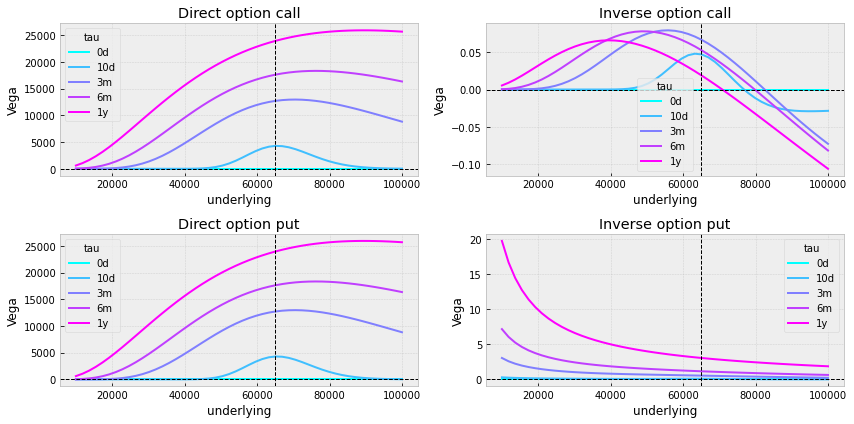

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
(terminal_payoff_data
 .query('class_name == "DirectOption" and call_or_put == "call"')
 .pivot_table('vega', index='underlying', columns='tau')
 .reindex(columns=tau_map)
 .plot(cmap='cool', ax=ax[0][0]))
(terminal_payoff_data
 .query('class_name == "DirectOption" and call_or_put == "put"')
 .pivot_table('vega', index='underlying', columns='tau')
 .reindex(columns=tau_map)
 .plot(cmap='cool', ax=ax[1][0]))

(terminal_payoff_data
 .query('class_name == "InverseOption" and call_or_put == "call"')
 .pivot_table('vega', index='underlying', columns='tau')
 .reindex(columns=tau_map)
 .plot(cmap='cool', ax=ax[0][1]))
(terminal_payoff_data
 .query('class_name == "InverseOption" and call_or_put == "put"')
 .pivot_table('vega', index='underlying', columns='tau')
 .reindex(columns=tau_map)
 .plot(cmap='cool', ax=ax[1][1]));

axes = ax.flatten()
for i in axes:
    i.axhline(0, color='black', lw=1, ls='--')
    i.axvline(strike, color='black', lw=1, ls='--')
    i.set_ylabel('Vega')

ax[0][0].set_title('Direct option call')
ax[1][0].set_title('Direct option put')

ax[0][1].set_title('Inverse option call')
ax[1][1].set_title('Inverse option put')
fig.tight_layout()

# Implication for volatility

As can be seen in the charts above as well as [1], the relationship with respest to $\sigma$ is somewhat counterintuitive compared to the usual direct option.

In [12]:
sigma_list = np.linspace(0.01, 10)

In [13]:
underlying = 60000
options = [direct_call, direct_put, inverse_call, inverse_put]
sigma_data = []

for tau, sigma, trade in product(tau_map.keys(), sigma_list, options):
    tau_float = tau_map[tau]
    sigma_data.append([
        tau, sigma, trade.__class__.__name__, trade.call_or_put, 
        trade.pv(underlying, sigma, tau_float, r, div),
    ])
    
sigma_data = pd.DataFrame(sigma_data, 
                          columns=['tau', 'sigma', 'class_name', 'call_or_put', 'pv'])

For direct options, vega is always positive no matter how big sigma becomes although it diminishes as sigma increases. On the other hand, the vega for inverse options can turn negative as sigma increases. 

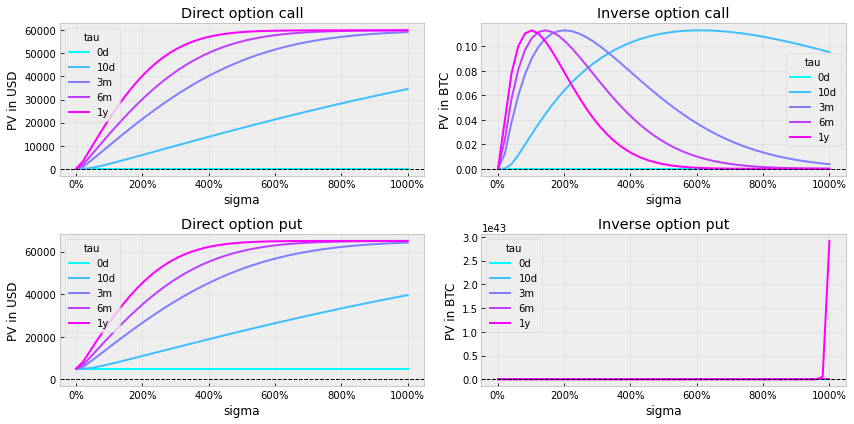

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
(sigma_data
 .query('class_name == "DirectOption" and call_or_put == "call"')
 .pivot_table('pv', index='sigma', columns='tau')
 .reindex(columns=tau_map)
 .plot(cmap='cool', ax=ax[0][0]))
(sigma_data
 .query('class_name == "DirectOption" and call_or_put == "put"')
 .pivot_table('pv', index='sigma', columns='tau')
 .reindex(columns=tau_map)
 .plot(cmap='cool', ax=ax[1][0]))

(sigma_data
 .query('class_name == "InverseOption" and call_or_put == "call"')
 .pivot_table('pv', index='sigma', columns='tau')
 .reindex(columns=tau_map)
 .plot(cmap='cool', ax=ax[0][1]))
(sigma_data
 .query('class_name == "InverseOption" and call_or_put == "put"')
 .pivot_table('pv', index='sigma', columns='tau')
 .reindex(columns=tau_map)
 .plot(cmap='cool', ax=ax[1][1]));

axes = ax.flatten()
for i in axes:
    i.axhline(0, color='black', lw=1, ls='--')
    i.xaxis.set_major_formatter(mticker.PercentFormatter(1))
    
ax[0][0].set_title('Direct option call')
ax[1][0].set_title('Direct option put')
ax[0][0].set_ylabel('PV in USD')
ax[1][0].set_ylabel('PV in USD')

ax[0][1].set_title('Inverse option call')
ax[1][1].set_title('Inverse option put')
ax[0][1].set_ylabel('PV in BTC')
ax[1][1].set_ylabel('PV in BTC')
fig.tight_layout()

This observation holds even if inverse options are converted in USD.

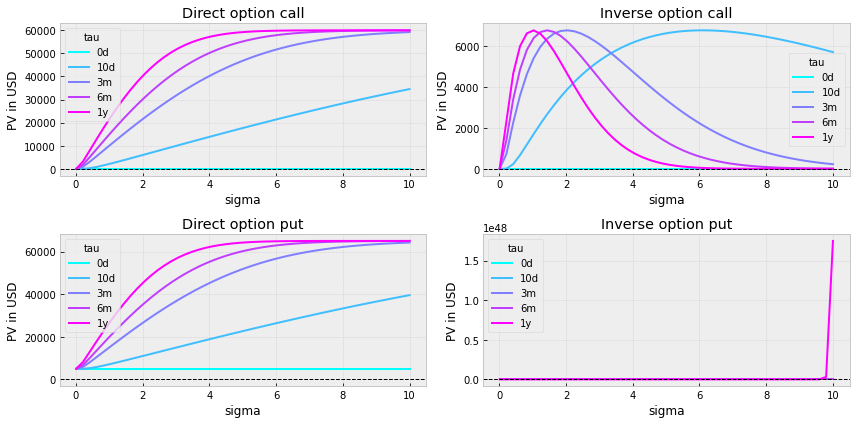

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
(sigma_data
 .query('class_name == "DirectOption" and call_or_put == "call"')
 .pivot_table('pv', index='sigma', columns='tau')
 .reindex(columns=tau_map)
 .plot(cmap='cool', ax=ax[0][0]))
(sigma_data
 .query('class_name == "DirectOption" and call_or_put == "put"')
 .pivot_table('pv', index='sigma', columns='tau')
 .reindex(columns=tau_map)
 .plot(cmap='cool', ax=ax[1][0]))

(sigma_data
 .query('class_name == "InverseOption" and call_or_put == "call"')
 .assign(
     pv_in_usd=lambda df: df['pv'] * underlying
 )
 .pivot_table('pv_in_usd', index='sigma', columns='tau')
 .reindex(columns=tau_map)
 .plot(cmap='cool', ax=ax[0][1]))
(sigma_data
 .query('class_name == "InverseOption" and call_or_put == "put"')
 .assign(
     pv_in_usd=lambda df: df['pv'] * underlying
 )
 .pivot_table('pv_in_usd', index='sigma', columns='tau')
 .reindex(columns=tau_map)
 .plot(cmap='cool', ax=ax[1][1]));

axes = ax.flatten()
for i in axes:
    i.axhline(0, color='black', lw=1, ls='--')
    i.set_ylabel('PV in USD')

ax[0][0].set_title('Direct option call')
ax[1][0].set_title('Direct option put')

ax[0][1].set_title('Inverse option call')
ax[1][1].set_title('Inverse option put')
fig.tight_layout()

# Put call parity

With the option price formula, the put call parity is written as follows:
$$
F \left(C - P\right) = F e^{-r \tau} - e^{\left(y-r+\sigma^2\right) \tau}K
$$

Note that the formula in [1] appears incorrect.
The put call parity can be used to compute the implied perpetual futures prices $F$ from observed option prices.

One notable difference from the direct option is that there is $\sigma$ in the put call parity formula. This means in order to solve the implied futures price, one needs to  simultaneously solve the implied volatility $\sigma$ such that $\sigma_{imp, call, K} = \sigma_{imp, put, K}$. In practice, this numerical calculation appears to be rather unstable and often there is no solution to satisfy all the conditions, maybe because ITM options are not updated as often as OTM. It's not entirely clear how this issue is addressed in [1].

# Implied volatility surface

## BTC

First load the snapshot of options prices as of `value_date`.

In [16]:
value_date = datetime(2022, 5, 5, 16)
option_snapshot = get_deribit_option_snapshot('BTC', value_date)
option_snapshot.shape

(176, 4)

In [17]:
option_snapshot.head()

,strike,option_type,expiry,close
0,35000,Call,2022-05-06 08:00:00,0.0820
1,38000,Call,2022-05-06 08:00:00,0.0035
2,40000,Call,2022-05-06 08:00:00,0.0010
3,42000,Call,2022-05-06 08:00:00,0.0005
4,35000,Put,2022-05-06 08:00:00,0.0015


Also get the underlying perpetual futures price as of `value_date`. Only OTM option prices are used to calculate the volatility surface.

In [18]:
perp_ts = get_perpetual_futures('BTCUSD', 'deribit')

In [19]:
def post_process_option_data(option_snapshot, perp_ts):
    option_snapshot = (
        option_snapshot
        .assign(
            underlying=perp_ts.loc[value_date, 'close'],
            expiry_cl=option_snapshot['expiry'].apply(lambda x: int(x.strftime('%Y%m%d')))
        )
        .assign(
            is_otm=lambda df: np.where(df['option_type'] == 'Call', 
                                       df['strike'] >= df['underlying'], 
                                       df['strike'] < df['underlying'])
        )
        .query('is_otm == True')
    )
    return option_snapshot

In [20]:
option_snapshot = post_process_option_data(option_snapshot, perp_ts)

In [21]:
option_snapshot.head()

,strike,option_type,expiry,close,underlying,expiry_cl,is_otm
1,38000,Call,2022-05-06 08:00:00,0.0035,36832.0,20220506,True
2,40000,Call,2022-05-06 08:00:00,0.0010,36832.0,20220506,True
3,42000,Call,2022-05-06 08:00:00,0.0005,36832.0,20220506,True
4,35000,Put,2022-05-06 08:00:00,0.0015,36832.0,20220506,True
9,37000,Call,2022-05-07 08:00:00,0.0155,36832.0,20220507,True


For a comparison, both direct and inverse options are used to back out implied volatility (`implied_vol_direct` and `implied_vol_inverse`). Note the root finding for inverse options tends to fail more than direct options. As a result, the volatility surface for inverse options is a bit scarse compared to that of direct options.

In [22]:
def calc_implied_volatility(option_snapshot):
    for idx, row in option_snapshot.iterrows():
        call_or_put = row['option_type']

        if call_or_put == 'Call':
            trade_inverse = InverseOption(row['strike'], 1)
            trade_direct = DirectOption(row['strike'], 1)
        else:
            trade_inverse = InverseOption(row['strike'], -1)
            trade_direct = DirectOption(row['strike'], -1)

        tau = (row['expiry'] - value_date).total_seconds() / (60 * 60 * 24 * 365.25)

        implied_vol_inverse = trade_inverse.implied_volatility(row['close'], row['underlying'], tau, 0, 0)
        implied_vol_direct = trade_direct.implied_volatility(row['close'] * row['underlying'], row['underlying'], tau, 0, 0)

        option_snapshot.at[idx, 'implied_vol_inverse'] = implied_vol_inverse
        option_snapshot.at[idx, 'implied_vol_direct'] = implied_vol_direct
    return option_snapshot

In [23]:
option_snapshot = calc_implied_volatility(option_snapshot)

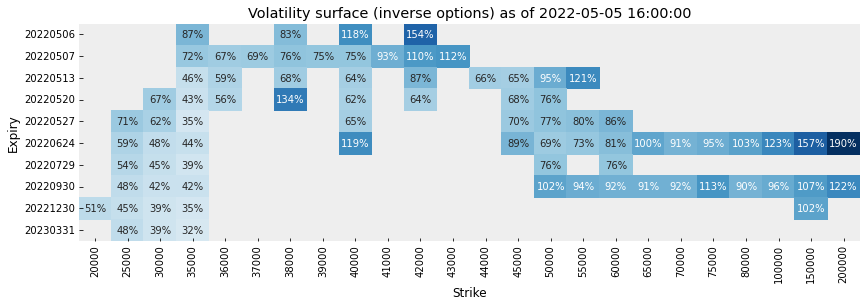

In [24]:
fig, ax = plt.subplots(figsize=(14, 4))
(option_snapshot.pivot_table('implied_vol_inverse', index='expiry_cl', columns='strike')
 .pipe(sns.heatmap, ax=ax, cmap='RdBu', center=0, annot=True, fmt='.0%', cbar=False))
ax.set_title(f'Volatility surface (inverse options) as of {value_date}')
ax.set_ylabel('Expiry')
ax.set_xlabel('Strike');

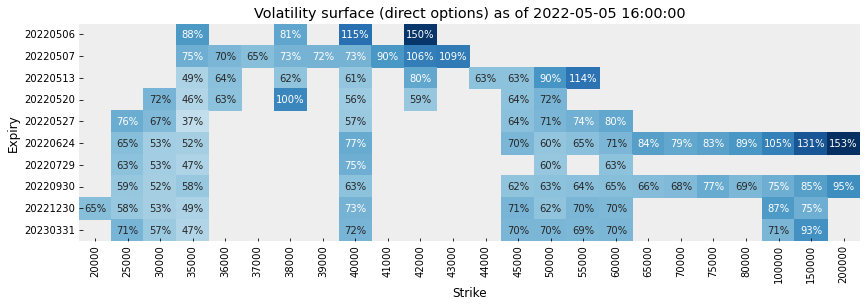

In [25]:
fig, ax = plt.subplots(figsize=(14, 4))
(option_snapshot.pivot_table('implied_vol_direct', index='expiry_cl', columns='strike')
 .pipe(sns.heatmap, ax=ax, cmap='RdBu', center=0, annot=True, fmt='.0%', cbar=False))
ax.set_title(f'Volatility surface (direct options) as of {value_date}')
ax.set_ylabel('Expiry')
ax.set_xlabel('Strike');

As reported in [1], the implied volatility for OTM call options tends to be higher than the direct option counterpart. Interestingly, the opposite is true for OTM put options -- i.e., the implied vol based on the inverse option is lower than the direct option. Another interesting observation is the implied vol and Greeks shown on the Deribit web site appear to be based on the direct option formula.

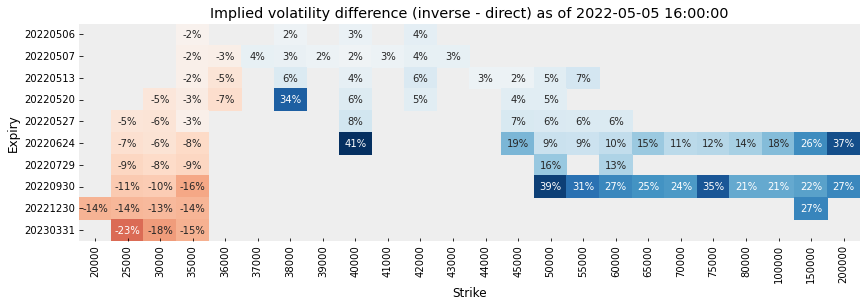

In [26]:
fig, ax = plt.subplots(figsize=(14, 4))
(option_snapshot.assign(
    inverse_less_direct=lambda df: df['implied_vol_inverse'] - df['implied_vol_direct']
).pivot_table('inverse_less_direct', index='expiry_cl', columns='strike')
 .pipe(sns.heatmap, ax=ax, cmap='RdBu', center=0, annot=True, fmt='.0%', cbar=False))
ax.set_title(f'Implied volatility difference (inverse - direct) as of {value_date}')
ax.set_ylabel('Expiry')
ax.set_xlabel('Strike');

## ETH

In [27]:
option_snapshot = get_deribit_option_snapshot('ETH', value_date)

In [28]:
perp_ts = get_perpetual_futures('ETHUSD', 'deribit')

In [29]:
option_snapshot = post_process_option_data(option_snapshot, perp_ts)

In [30]:
option_snapshot = calc_implied_volatility(option_snapshot)

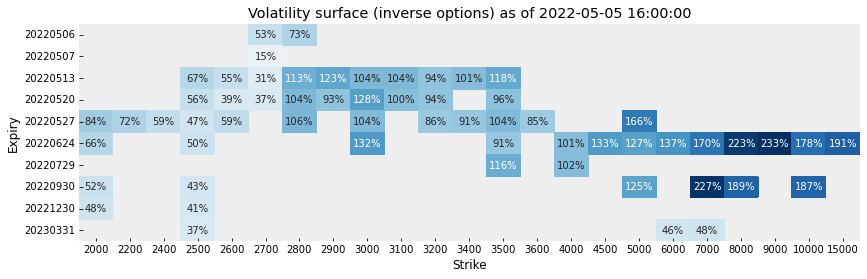

In [31]:
fig, ax = plt.subplots(figsize=(14, 4))
(option_snapshot.pivot_table('implied_vol_inverse', index='expiry_cl', columns='strike')
 .pipe(sns.heatmap, ax=ax, cmap='RdBu', center=0, annot=True, fmt='.0%', cbar=False))
ax.set_title(f'Volatility surface (inverse options) as of {value_date}')
ax.set_ylabel('Expiry')
ax.set_xlabel('Strike');

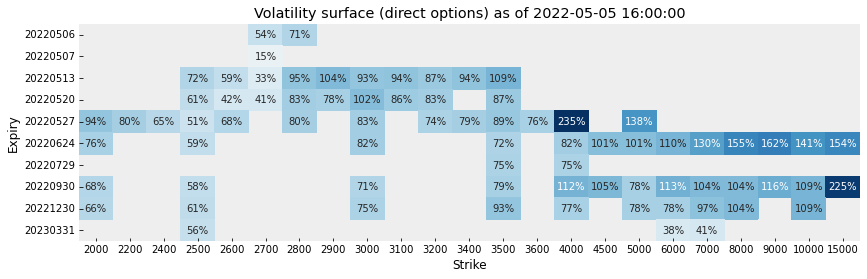

In [32]:
fig, ax = plt.subplots(figsize=(14, 4))
(option_snapshot.pivot_table('implied_vol_direct', index='expiry_cl', columns='strike')
 .pipe(sns.heatmap, ax=ax, cmap='RdBu', center=0, annot=True, fmt='.0%', cbar=False))
ax.set_title(f'Volatility surface (direct options) as of {value_date}')
ax.set_ylabel('Expiry')
ax.set_xlabel('Strike');

The same pattern can be observed in the ETH option market.

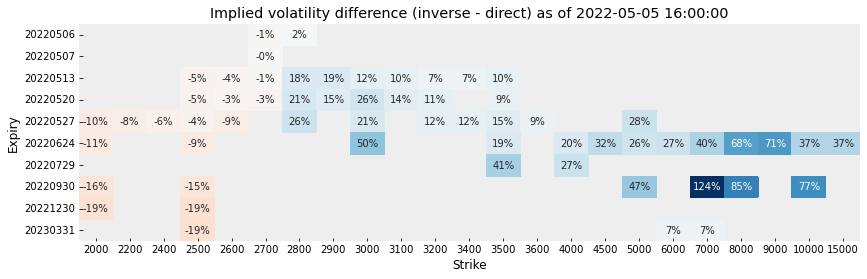

In [33]:
fig, ax = plt.subplots(figsize=(14, 4))
(option_snapshot.assign(
    inverse_less_direct=lambda df: df['implied_vol_inverse'] - df['implied_vol_direct']
).pivot_table('inverse_less_direct', index='expiry_cl', columns='strike')
 .pipe(sns.heatmap, ax=ax, cmap='RdBu', center=0, annot=True, fmt='.0%', cbar=False))
ax.set_title(f'Implied volatility difference (inverse - direct) as of {value_date}')
ax.set_ylabel('Expiry')
ax.set_xlabel('Strike');

# Reference
- Alexander, C. and Imeraj, A., 2021. Inverse Options in a Black-Scholes World. arXiv preprint arXiv:2107.12041.